# Inicializacion de la Base de Datos

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate
import seaborn as sns
from IPython import get_ipython
from IPython.display import display
import patoolib
import os
import re

# Extraer archivo RAR automaticamente
os.makedirs("carpeta_de_extraccion", exist_ok=True) 
patoolib.extract_archive("Base_de_datos.rar", outdir="carpeta_de_extraccion")


# Leer el archivo JSON en un DataFrame de pandas
df_json = pd.read_json('carpeta_de_extraccion/Base_de_datos/harmonized.json', lines=True)

INFO patool: Extracting Base_de_datos.rar ...
INFO patool: running "C:\Program Files\WinRAR\rar.EXE" x -kb -or -- c:\Users\salce\Desktop\prueba\Base_de_datos.rar
INFO patool: ... Base_de_datos.rar extracted to `carpeta_de_extraccion'.


# Analisis de Datos y Funciones

In [45]:
def transformar_texto(serie): 
    df_json[serie] = df_json[serie].str.upper().str.replace(r'[.,;:]', '', regex=True).str.replace(r' INC ', '', regex=True).str.replace(r' INC', '', regex=True)
    return df_json[serie]

def eliminar_numeros(serie): 
    df_json[serie] = df_json[serie].str.upper().str.replace(r'[0123456789]', '', regex=True)
    df_json[serie] = df_json[serie].replace(r'^\s*$', pd.NA, regex=True)
    df_json[serie] = df_json[serie].dropna()
    return df_json[serie]

eliminar_numeros('application_number')
transformar_texto('generic_name')
transformar_texto('manufacturer_name')
transformar_texto('dosage_form')
eliminar_numeros('substance_name')


def conteo_de_elementos(serie, delimitadores=None):
    if delimitadores:
        delimitador_regex = '|'.join(map(re.escape, delimitadores))
        nuevas_columnas = serie.str.split(delimitador_regex, expand=True)
        value_counts = nuevas_columnas.apply(pd.Series.value_counts).sum(axis=1).astype(int)
        value_counts = value_counts[value_counts.index.notna()]
        value_counts = value_counts.drop('', errors='ignore')
    else:
        value_counts = serie.value_counts().astype(int)
    return value_counts

def grafica_top_10_barras(serie, titulo): 
    top_10 = serie.dropna().nlargest(10)
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x=top_10.values, y=top_10.index, palette="viridis") 
    ax.set_title(f'{titulo}', fontsize=15, pad=20) 
    ax.set_xlabel('Cantidad', fontsize=12) 
    ax.set_ylabel('Elementos', fontsize=12)
    for i, (value, name) in enumerate(zip(top_10.values, top_10.index)): 
        ax.text(value, i, f' {value}', color='black', va='center')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def grafica_top_10_histograma(serie, titulo): 
    top_10 = serie.nlargest(10)
    sns.set(style="whitegrid") 
    plt.figure(figsize=(14, 8)) 
    colors = sns.color_palette("viridis", len(top_10)) 
    ax = plt.gca() 
    for i, (value, name) in enumerate(zip(top_10.values, top_10.index)): 
        ax.bar(name, value, color=colors[i]) 
        ax.text(i, value, f'{value}', ha='center', color='black')
    ax.set_title(f'{titulo}', fontsize=15, pad=20) 
    ax.set_xlabel('Elementos', fontsize=12) 
    ax.set_ylabel('Frecuencia', fontsize=12) 
    plt.xticks(rotation=45) 
    plt.tight_layout() 
    plt.show()

def grafica_top_10_pastel(serie, titulo): 
    serie = serie.dropna()
    top_10 = serie.nlargest(10)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 10))
    if len(top_10) == 2:
        colors = ['#482173', '#c2df23']
    else:
        colors = sns.color_palette("viridis", len(top_10))
    plt.pie(top_10.values, labels=top_10.index, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f'{titulo}', fontsize=15, pad=20)
    plt.axis('equal')
    plt.show()

def visualizar_datos_farmaceuticos(serie1, serie2, titulo):
    serie1 = serie1.dropna()
    serie2 = serie2.dropna()
    common_index = serie1.index.intersection(serie2.index)
    serie1 = serie1.loc[common_index]
    serie2 = serie2.loc[common_index]
    top_dosage_forms = serie1.value_counts().nlargest(10).index
    top_product_types = serie2.value_counts().nlargest(10).index
    serie1 = serie1[serie1.isin(top_dosage_forms)]
    serie2 = serie2[serie2.isin(top_product_types)]
    contingencia = pd.crosstab(serie1, serie2, normalize='index')
    if not contingencia.empty:
        plt.figure(figsize=(9, 6))
        sns.heatmap(contingencia, cmap='viridis', annot=True, fmt='.2f', cbar=False)
        plt.title(f'{titulo}', fontsize=10)
        plt.xlabel('Distribuciones', fontsize=12)
        plt.ylabel('Elementos', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos suficientes para generar el heatmap.")

def grafica_histograma_dosificacion(df):
    df_dosage_counts = df['dosage_form'].value_counts().reset_index()
    df_dosage_counts.columns = ['dosage_form', 'product_count']
    top_n = 9
    top_dosage_forms = df_dosage_counts.nlargest(top_n, 'product_count')
    otros_count = df_dosage_counts[~df_dosage_counts['dosage_form'].isin(top_dosage_forms['dosage_form'])]['product_count'].sum()
    plot_data = top_dosage_forms.copy()
    otros_row = pd.DataFrame({
        'dosage_form': ['Otros'],
        'product_count': [otros_count]
    })
    plot_data = pd.concat([plot_data, otros_row], ignore_index=True)
    colores = sns.color_palette("viridis", top_n + 1)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(plot_data['dosage_form'], plot_data['product_count'], color=colores)
    plt.title('Productos por Formas de Dosificacion', fontsize=16)
    plt.xlabel('Elementos', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:,.0f}', 
                 ha='center', va='bottom', fontsize=10)
    plt.tight_layout()

# Graficas

C:\Users\salce\AppData\Local\Temp\ipykernel_10184\2839171532.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10.values, y=top_10.index, palette="viridis")


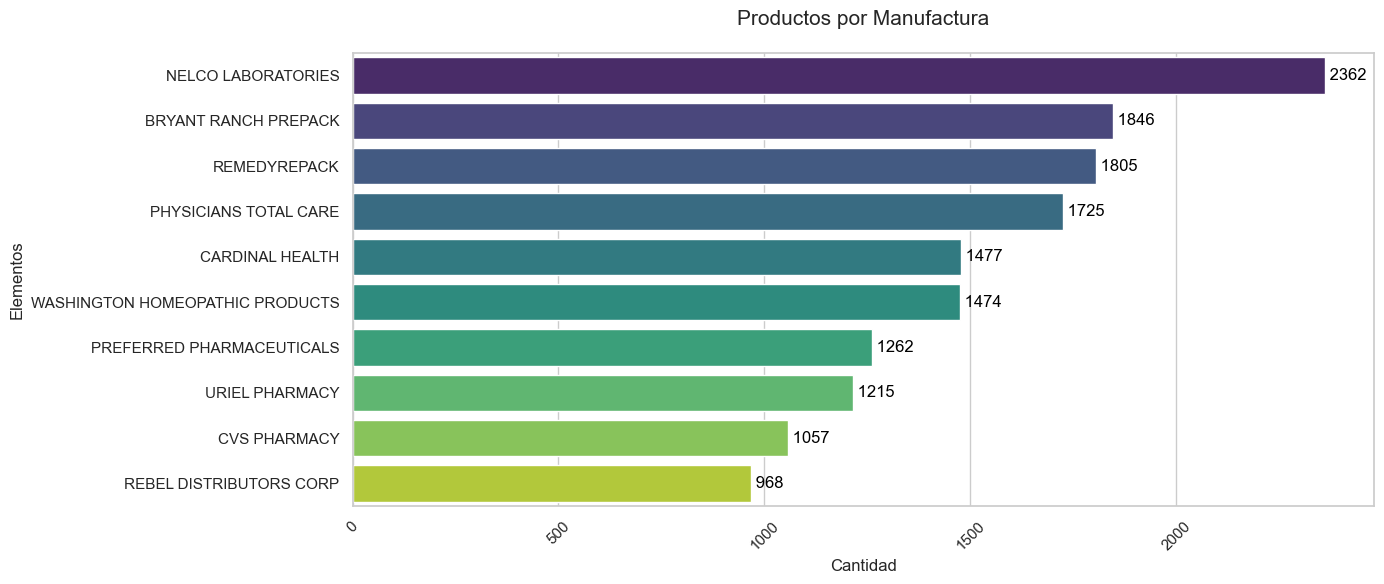

In [46]:
grafica_top_10_barras(conteo_de_elementos(df_json['manufacturer_name']),'Productos por Manufactura')

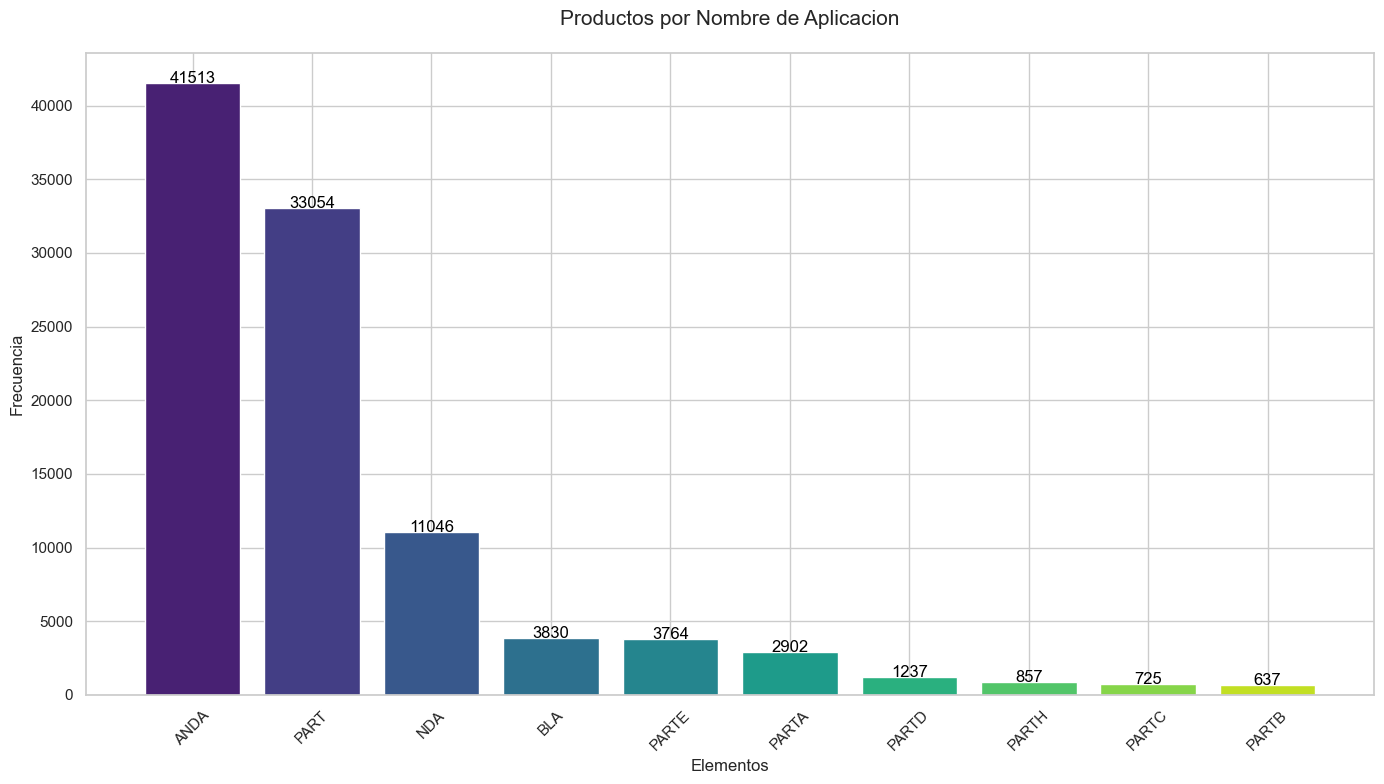

In [47]:
grafica_top_10_histograma(conteo_de_elementos(df_json['application_number']),'Productos por Nombre de Aplicacion')

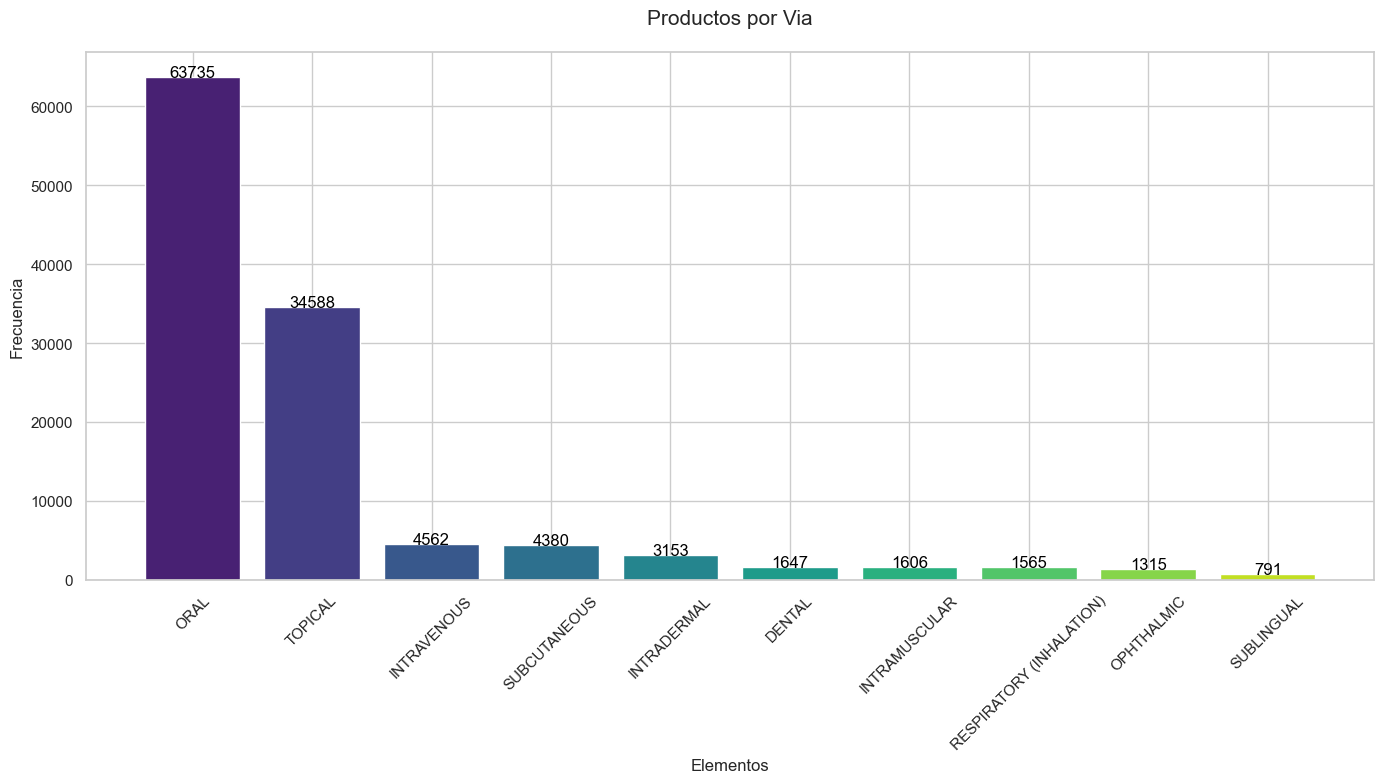

In [48]:
delimitadores = ['; ']
grafica_top_10_histograma(conteo_de_elementos(df_json['route'],delimitadores), 'Productos por Via')

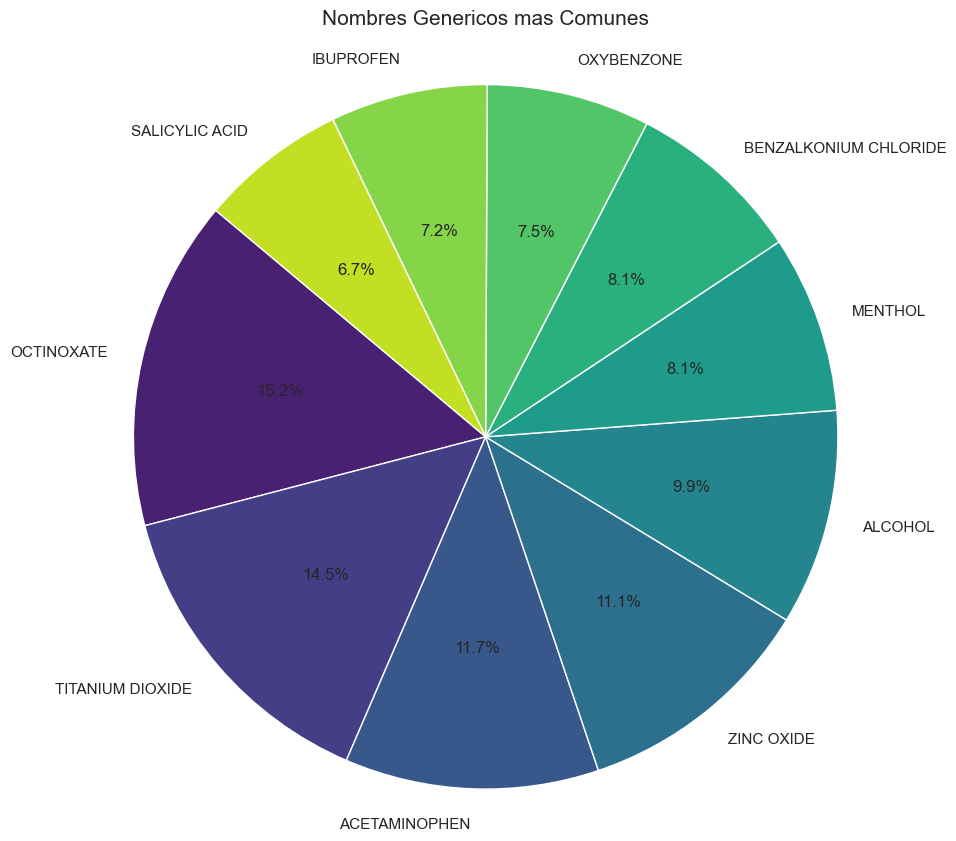

In [49]:
delimitadores = [', ', ' - ', ' and ', 'and ', ',', ' AND ','AND ' , '-']
grafica_top_10_pastel(conteo_de_elementos(df_json['generic_name'],delimitadores),'Nombres Genericos mas Comunes')

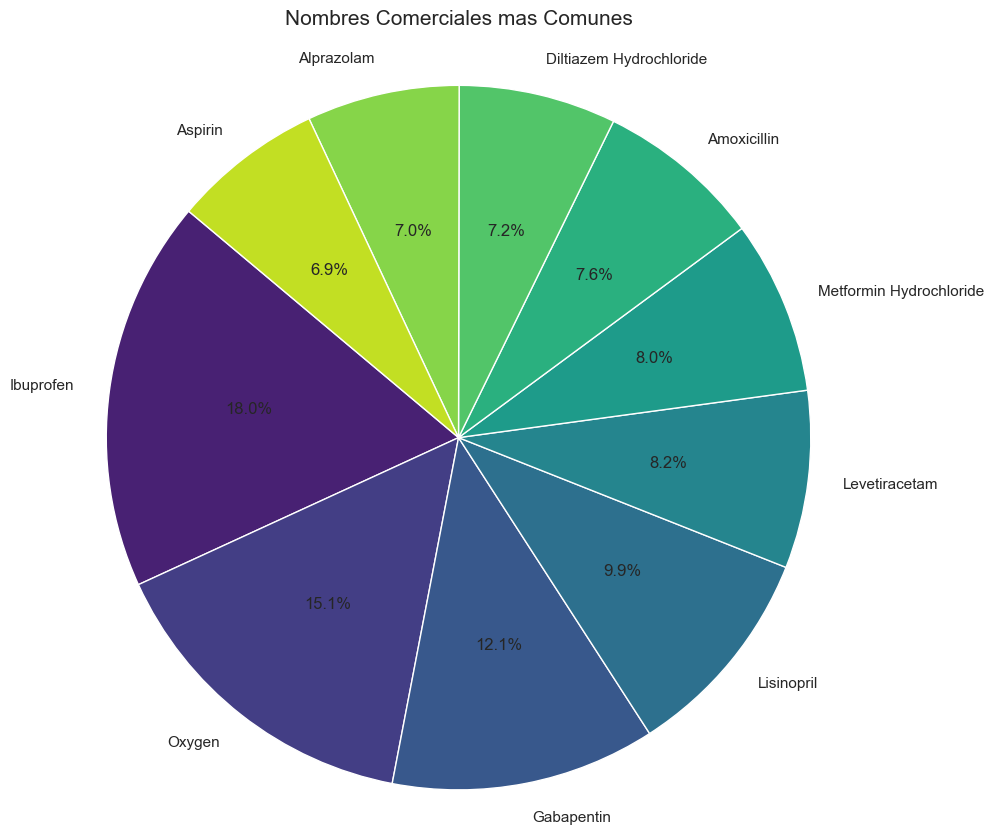

In [50]:
grafica_top_10_pastel(conteo_de_elementos(df_json['brand_name']),'Nombres Comerciales mas Comunes')

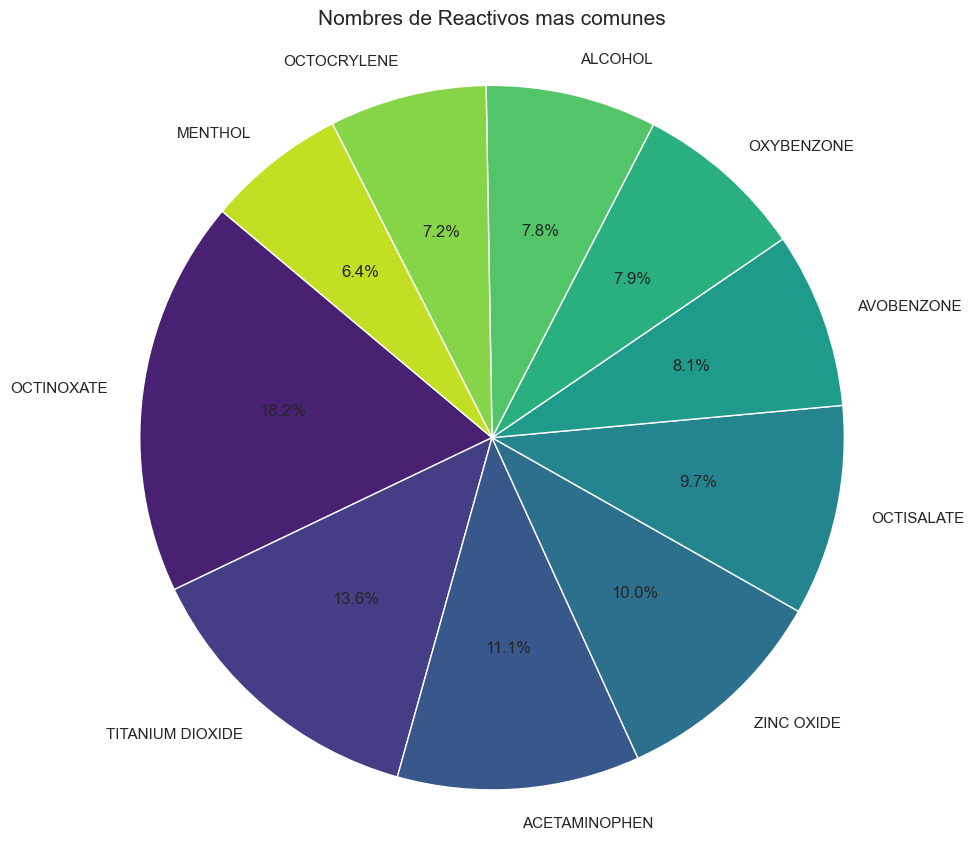

In [51]:
delimitadores = ['; ']
grafica_top_10_pastel(conteo_de_elementos(df_json['substance_name'], delimitadores),'Nombres de Reactivos mas comunes')

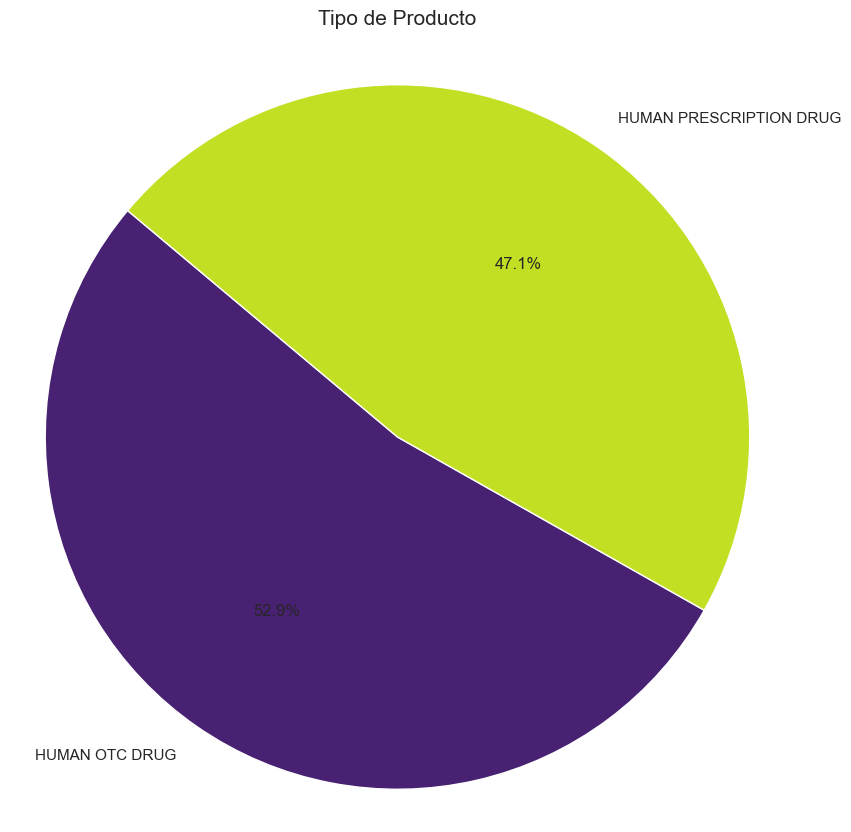

In [52]:
grafica_top_10_pastel(conteo_de_elementos(df_json["product_type"]), 'Tipo de Producto')

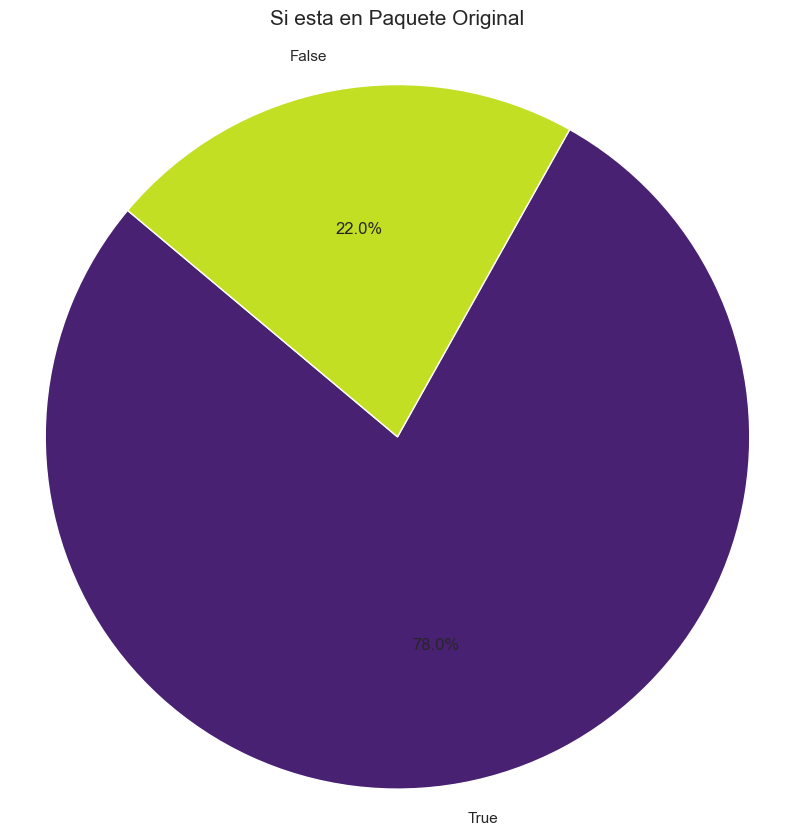

In [53]:
grafica_top_10_pastel(conteo_de_elementos(df_json['is_original_packager']),'Si esta en Paquete Original')

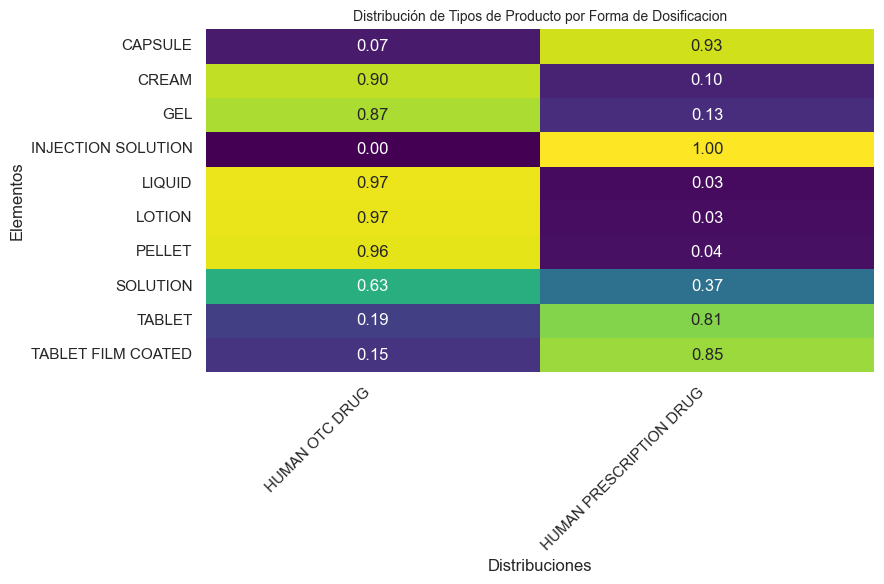

None


In [54]:
print(visualizar_datos_farmaceuticos(df_json['dosage_form'], df_json['product_type'], 'Distribución de Tipos de Producto por Forma de Dosificacion'))

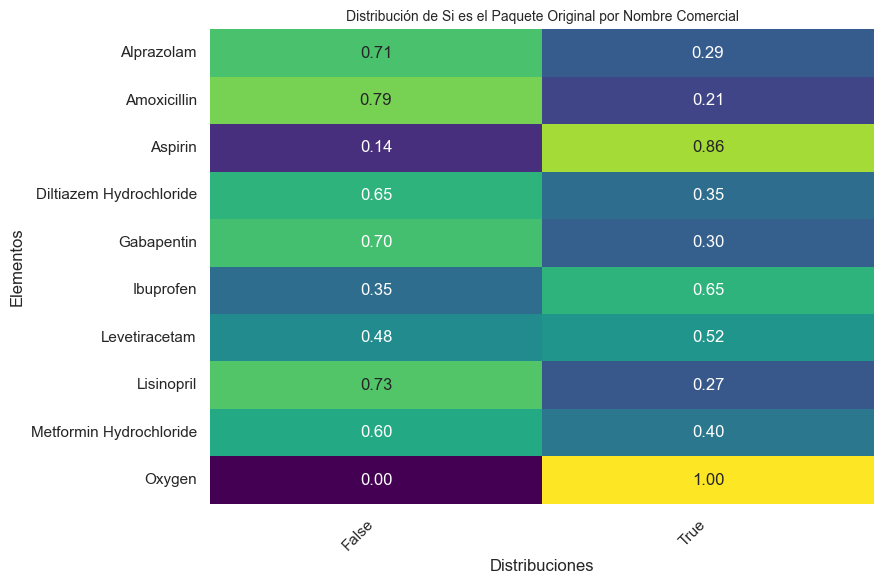

None


In [55]:
print(visualizar_datos_farmaceuticos(df_json['brand_name'], df_json['is_original_packager'], 'Distribución de Si es el Paquete Original por Nombre Comercial'))

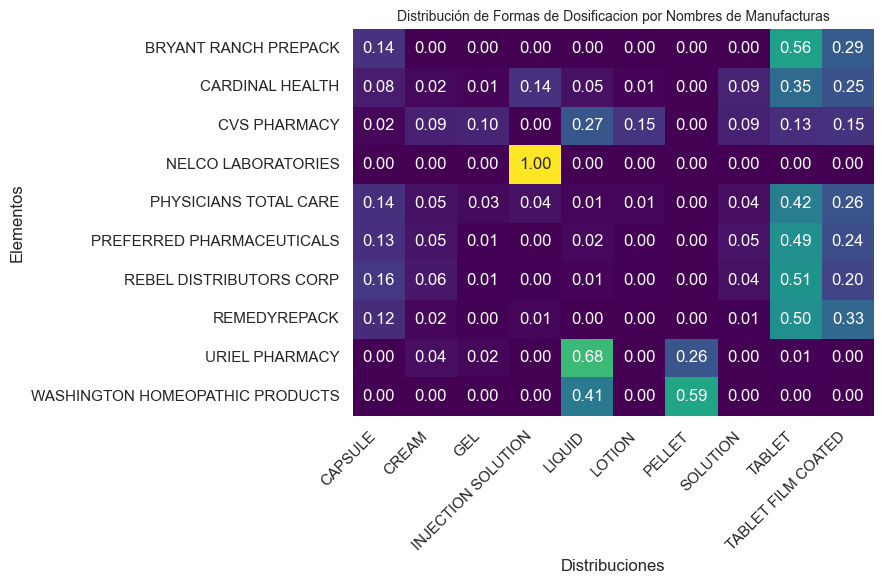

None


In [56]:
print(visualizar_datos_farmaceuticos(df_json['manufacturer_name'], df_json['dosage_form'], 'Distribución de Formas de Dosificacion por Nombres de Manufacturas'))

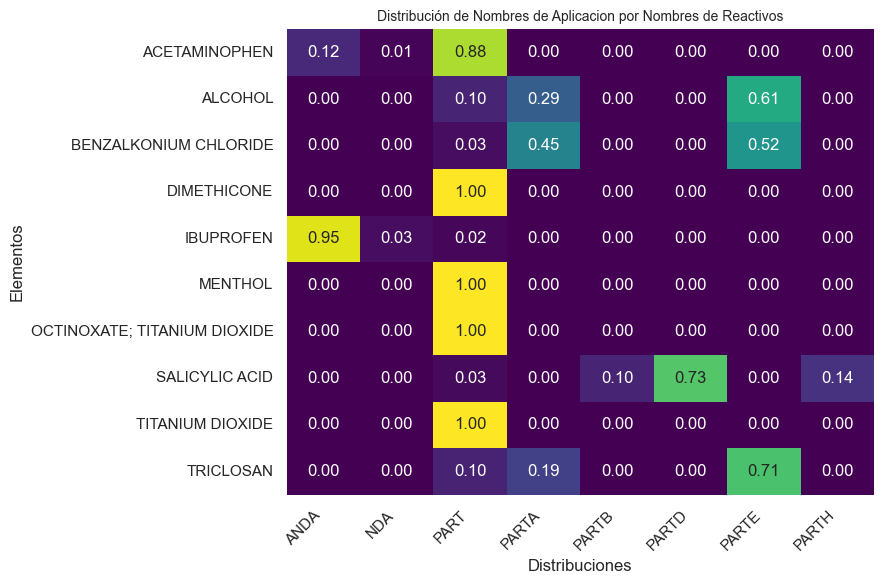

None


In [57]:
print(visualizar_datos_farmaceuticos(df_json['substance_name'], df_json['application_number'], 'Distribución de Nombres de Aplicacion por Nombres de Reactivos'))

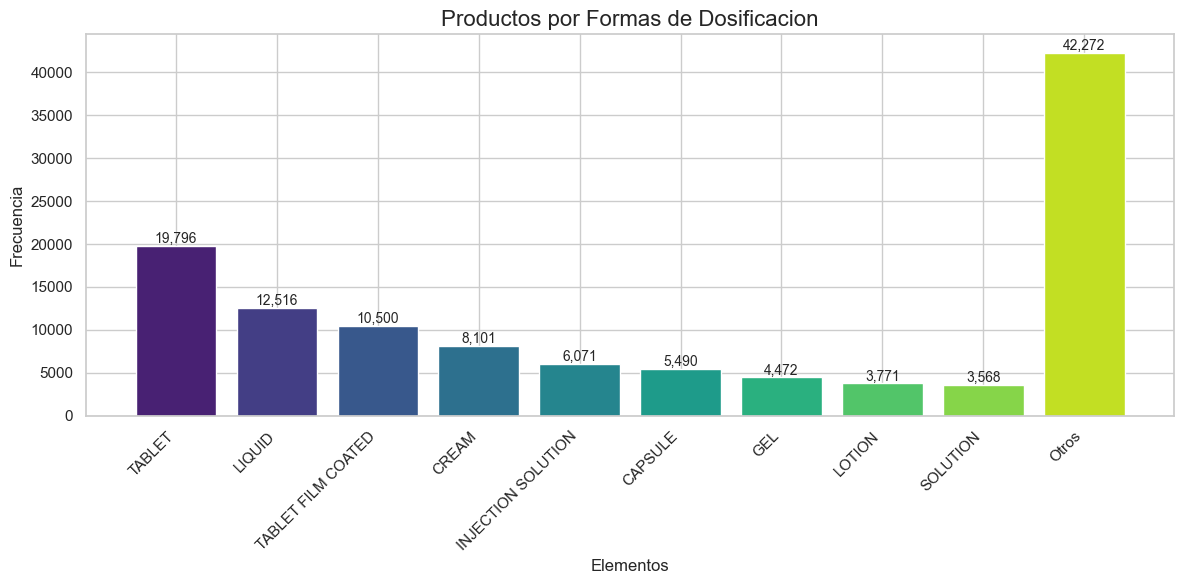

In [58]:
grafica_histograma_dosificacion(df_json)

# Busqueda de Medicamento

In [ ]:
df_bus = df_json[['brand_name', 'substance_name']]
df_bus.columns = ['brand_name', 'substance_name']
df_bus = df_bus.drop_duplicates()

def separar_componentes(serie, delimitadores=None):
    if delimitadores:
        delimitador_regex = ' '.join(map(re.escape, delimitadores))
        df_bus_new = serie.str.split(delimitador_regex, expand=True)
    else:
        df_bus_new = serie.str.split(expand=True)
    df_bus_new.columns = [f'Componente_{i+1}' for i in range(df_bus_new.shape[1])]
    return df_bus_new

df_bus_new = separar_componentes(df_bus['substance_name'], ['; '])
df_bus_new['brand_name'] = df_bus['brand_name']
df_bus_new = df_bus_new.set_index('brand_name')


### Farmacias Ficticias


df1 = df_bus_new.sample(n=len(df_bus_new)//3, replace=True)
df2 = df_bus_new.sample(n=len(df_bus_new)//3, replace=True)
df3 = df_bus_new.sample(n=len(df_bus_new)//3, replace=True)

list_farms = {'Farmacia1':df1, 'Farmacia2':df2, 'Farmacia3':df3}


#### Medicamento a buscar


med = "Clean Force"

# Almacenar datos de los resultados de búsqueda

farm_esta_med = {}
farm_y_comp = {}
farm_no_med = {}
far_med_sml = {}


# Verificar la presencia del medicamento, obtener los componentes y saber en que farmacia no esta
for nom_farm, df_farm in list_farms.items():
    if med in df_farm.index:
        farm_esta_med[nom_farm] = f'Esta el medicamento {med}'
        df_bus_new = df_bus_new.loc[med]
        value_counts = df_bus_new.apply(pd.Series.value_counts).sum(axis=1).astype(int).index.tolist()
        farm_y_comp[nom_farm] = value_counts
    else:
        farm_no_med[nom_farm] = f'No esta el medicamento {med}'

if not farm_esta_med:
    farm_esta_med[nom_farm] = f'No asta el medicamento {med}'
    farm_y_comp[nom_farm] = f'Esta el medicamento {med}'


# Verificar en la farmacia que no se encontro si existe uno similar
if farm_esta_med:
    indices_lista = []
    def encontrar_primera_lista():
        for nombre, df in list_farms.items():
            for nom_far_no in farm_no_med:
                for nom_far, lista in farm_y_comp.items():
                    for i in lista:
                        indices = df.apply(lambda row: row == i, axis=1).any(axis=1)
                        indices_lista = df[indices].index.tolist()[:5]  # Guardar solo los primeros 5 resultados
                        if indices_lista:
                            far_med_sml[nom_far_no] = indices_lista
                            yield indices_lista  # Usar yield para retornar la lista y salir del generador
    indices_lista = next(encontrar_primera_lista(), [])
elif not farm_esta_med:
    print('No se encontro para comparar')

if not farm_no_med:
    farm_no_med[nom_farm] = f'Se encontro en todas las farmacias {med}'
    far_med_sml[nom_farm] = f'Se encontro en todas las farmacias {med}'


# Salida

def print_df_with_title(title, df_dict):
    df = pd.DataFrame(list(df_dict.items()), columns=['Farmacia', 'Estado'])
    print("-"*60)
    print(title)
    print(df.to_string(index=False, header=False))


print("Medicamento a buscar:", med)
print_df_with_title("En qua farmacia esta:", farm_esta_med)
print_df_with_title("Componentes por farmacia:", farm_y_comp)
print_df_with_title("En qua farmacia no esta:", farm_no_med)
print_df_with_title("Farmacia donde esta un medicamento similar:", far_med_sml)



Medicamento a buscar: Clean Force
------------------------------------------------------------
En qua farmacia esta:
Farmacia2 Esta el medicamento Clean Force
------------------------------------------------------------
Componentes por farmacia:
Farmacia2 [ALCOHOL, BENZALKONIUM CHLORIDE, TRICLOSAN]
------------------------------------------------------------
En qua farmacia no esta:
Farmacia1 No esta el medicamento Clean Force
Farmacia3 No esta el medicamento Clean Force
------------------------------------------------------------
Farmacia donde esta un medicamento similar:
Farmacia1 [Kay Actigel, KUB Cartridge Refeel Antiseptic ...]


